# Demo 1: Extreme Gradient Boosting XGBoosting
What is the difference between the R gbm and xgboosting?

The R gbm (gradient boosting machine) and xgboost (extreme gradient boosting) are both ensemble learning methods that use decision trees as base learners. However, there are some differences between the two:

-   xgboost is an optimized version of the gradient boosting algorithm. It is designed to be faster and more efficient than R gbm.

-   xgboost includes additional features such as regularization, which can help prevent overfitting in the model.

-   xgboost also includes a built-in parallel processing capability, which can help speed up the training process.

R gbm is implemented in the R programming language, whereas xgboost is implemented in C++.

Overall, xgboost is a more advanced and optimized version of the gradient boosting algorithm, but both methods can be used effectively for a wide range of machine learning tasks.

![Screenshot 2023-11-20 at 4.21.01 PM.png](<attachment:Screenshot 2023-11-20 at 4.21.01 PM.png>)


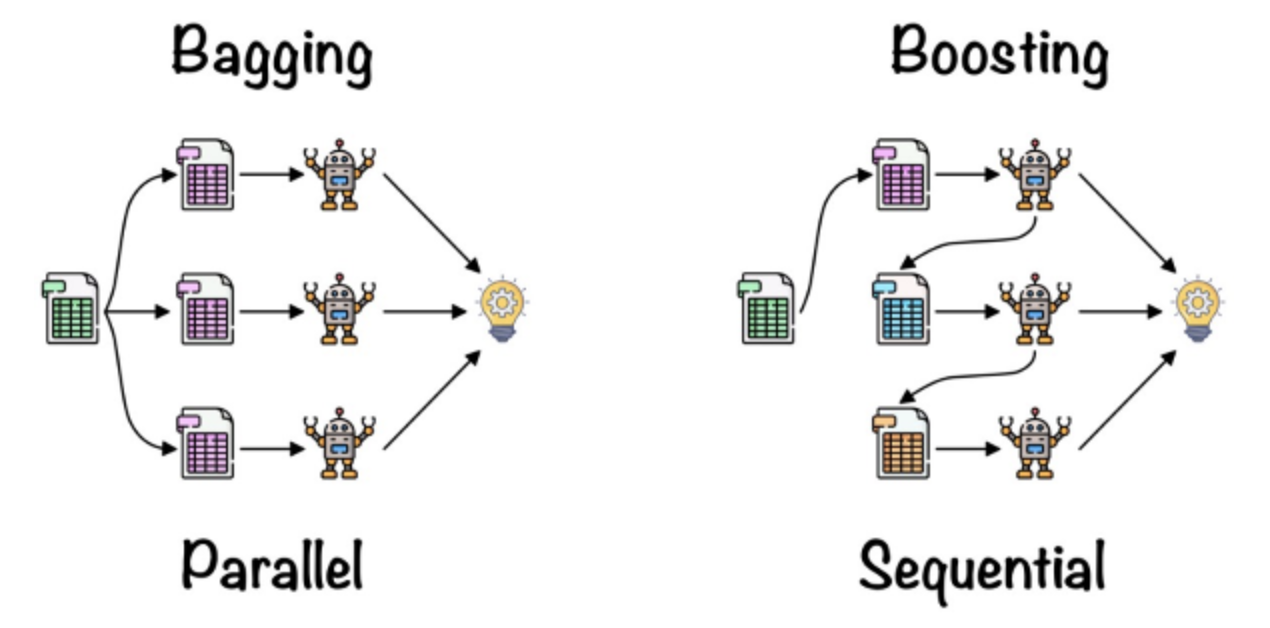

The XG Boosting model in this demo will also try to solve the classification problem as we have done before in the section S1_Classification:

-   Problem: Defect detection classification (with the NEU surface defect dataset)
-   Dataset: NEU surface defect dataset <http://faculty.neu.edu.cn/songkechen/zh_CN/zhym/263269/list/index.htm>(NEU SDD)
-   Library package:
    -   xgboost (Machine Learning models: XGBRegressor, XGBClassifier, XGBRanker,...)
    -   Scikit-Learn (Machine Learning models: KNN,SVM,Decision Tree,...)
    -   PIL (Simple image processing package: read, show, resize,...)
    -   Matplotlib (Plot package: visualize result,....)

Tasks Outlines:
## 0. Task 0: Preparing dataset
-   Downloads dataset, unpacking dataset,...
-   Transform it to input (features) and ouput (labels) where the model in Scikit-Learn can read, and training on,...
-   Normalize or standardlize dataset (we may do it after some evaluations on the raw data)
-   Devide dataset to trainset and testset (maybe one more validation_set) or using the cross validation to evaluate the performance of model
## 1. Task 1: XGB Classifier from xgboost package (library):
-   Getting a XGBclassifier
-   Training model on our trainset
-   Evaluating the performance of trained model on the testset
## 2. Task 2: Evaluating the performance by Cross Validation method.

## 3. Task 3: 

*****************************************************************************

# Import all packages

In [27]:
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
# import models
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

# import XGBClassifier
from xgboost import XGBClassifier

# import method to evaluate performance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import classification_report,ConfusionMatrixDisplay

## 0. Task 0: Preparing Dataset

Go to the notebook file: Demo_Read_NEU_dataset.ipynb to get detail of demo code for this step

### 0.1. Define a function get all paths to each image in the dataset and the class label of each image

In [28]:
def get_all_img_label_path(input_dir:str,
                            img_suffix = '.bmp')->(list,list):
    """
    parameters:
    -   input_dir: the directory to the data folder
    -   img_suffix: siffix type of image in the data folder to read
    output: a tuple of two lists:
    -   List of all path to each image in the data folder
    -   List of relative class for each image in the data folder
    """
    label_to_number = {"Cr":0,"In":1,"Pa":2,"PS":3,"RS":4,"Sc":5}
    list_img_paths = []
    list_labels = []
    for root,dirs,files in os.walk(input_dir):
        for file in files:
            file_name,file_suffix = os.path.splitext(file)
            if file_suffix == img_suffix:
                list_img_paths.append(os.path.join(root,file))
                list_labels.append(label_to_number[file_name[:2]])
    return (list_img_paths,list_labels)


### 0.2. Define a function to get all image array and its class label (which are in type np.array)
In this function we also resize the all image to the same new size = (width, height)

In [29]:
# Resize the image to small dimensional of width and height
def get_data(list_img_paths:list,
             list_labels:list,
             is_resize:bool= True,
             width:int = 8,
             height:int = 8) -> (np.array,np.array):
    """
    Parameters:
    -   list_img_paths: List of all paths to image in the data folder
    -   list_labels: The list of labels relative to each image in the list_img_paths
    -   is_resize: Default is True means resize all image in the dataset
        to the new size (width,height)
    -   width: The width size which we want to resize to
    -   height: The height size which we want to resize to

    Output: A tuple of two arrays
    -   data_array with shape (N,h,w), where
        -   N is the number of image
        -   h is the height
        -   w is the width
    -   label_array with shape (N,)
    """
    data = []
    for i in range(len(list_img_paths)):
        path_img = list_img_paths[i]
        img = Image.open(path_img)
        if is_resize:
            img = img.resize(size = (width,height),
                            resample=Image.BICUBIC)
        data.append(np.array(img))
    return (np.array(data),np.array(list_labels))

### 0.3. Getting data by using two previouse function

In [30]:
# Get the list of all path to images, and the list of relative labels
dir_NEUCLS = "/Users/user/Victor2023/Dataset/NEU-CLS"
list_img_paths,list_labels = get_all_img_label_path(input_dir=dir_NEUCLS,
                                                    img_suffix='.bmp')

width = 28
height = 28
X,y = get_data(list_img_paths=list_img_paths,
               list_labels=list_labels,
               is_resize=True,
               width=width,
               height= height)

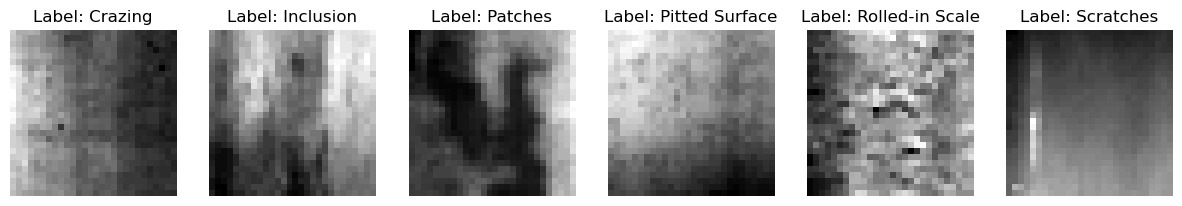

In [31]:
# Plotting some images to take an overview of our dataset
index_to_label = ["Crazing","Inclusion","Patches","Pitted Surface","Rolled-in Scale","Scratches"]
# Visualize one sample of each class
_, indices = np.unique(y,return_index=True) # get one index of each class
# Plot
_, axes = plt.subplots(nrows = 1,
                       ncols = len(indices),
                       figsize = (15,6))
for i in range(len(indices)):
    index = indices[i]
    axes[i].set_axis_off()
    axes[i].imshow(X[index], cmap = plt.cm.gray, interpolation= "nearest")
    axes[i].set_title(f"Label: {index_to_label[y[index]]}")

### Note!
The shape of data for KNN model should be (N_samples,N_features). In which:
-   N_samples: The total number of samples we have (number of images)
-   N_features: the number of features in each sample

Back to our data:
-   Data is image in grayscale we resize to same size (width,height), here is 28 x 28 pixels. Each pixels is one feature of sample, so totally we have 28*28 number of features for each sample.
-   We have to reshape our data from (N_samples,height,width) to (N_samples,height * width)


In [32]:
n_samples = X.shape[0]
X = X.reshape((n_samples,-1))
# Scaling feature from range [0,255] to range [0,1]
# Each pixel is a feature of input image, which has normally value in range [0,255] 
X = X/255

### 0.4. Deviding our dataset to trainset and testset

In [33]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,shuffle=False)

## 1. Task 1: XGB Classifier from xgboost
### 1.1. Getting the XGBClassifier

In [34]:
# Get the xgbclassifier
xgb_model = XGBClassifier()
# Training the model on the trainset
xgb_model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

### 1.2. Evaluating the performance of trained model on the testset 

In [35]:
# Predict on test set:
pred_test = xgb_model.predict(X_test)

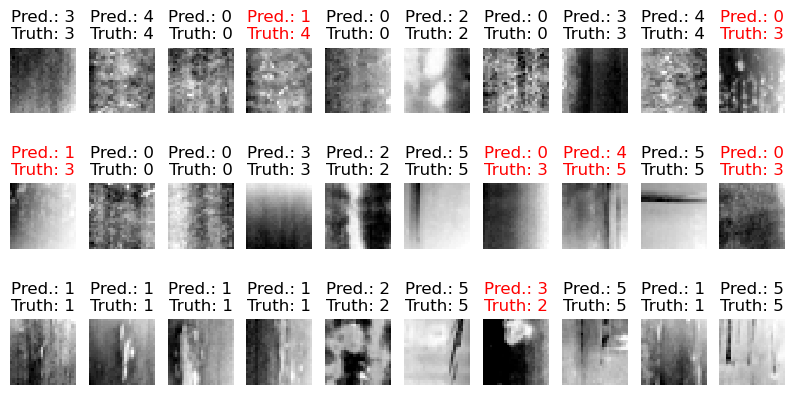

In [36]:
# Visualize the first 30 test samples and show their predicted digit value in the title.
_,axes = plt.subplots(nrows = 3,ncols = 10, figsize= (10,5))
for r in range(3):
    for c in range(10):
        index = r*10 + c
        axes[r,c].set_axis_off()
        image = X_test[index].reshape((width,height))
        pred_label = pred_test[index]
        true_label = y_test[index]
        axes[r,c].imshow(image, cmap = plt.cm.gray_r, interpolation = "nearest")
        if pred_label == true_label:
            axes[r,c].set_title(f"Pred.: {pred_label}\nTruth: {true_label}")
        else:
            axes[r,c].set_title(f"Pred.: {pred_label}\nTruth: {true_label}",color = 'red')

In [37]:
# Classification report:
print(f"Classification report for classifier {xgb_model}:\n"
      f"{classification_report(y_test,pred_test,digits=4)}\n")

Classification report for classifier XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...):
              precision    recall  f1-score   support

           0     0.6508    0.6308    0.6406        65
           1     0.6232    0.6418    0.6324        67
           2     0.9250    0.7872    0

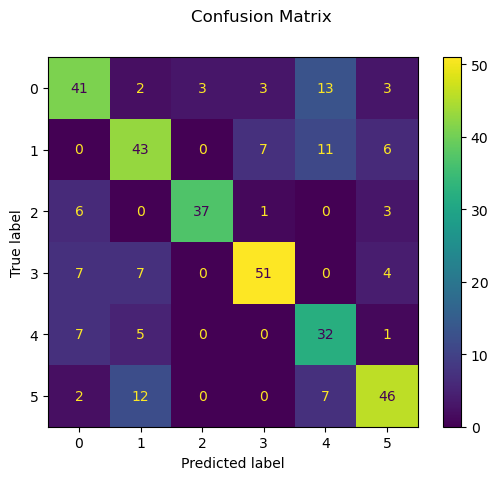

In [38]:
# Confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(y_test,pred_test)
disp.figure_.suptitle("Confusion Matrix")
# print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.show()

## 2. Task 2: Evaluating the performance of model by Cross Validation method.
We will compare cross validation score of xgbC model with the other six models

In [40]:
def get_models():
    models = dict()
    models['lr___'] = LogisticRegression(solver='lbfgs',max_iter=1000)
    models['knn__'] = KNeighborsClassifier(n_neighbors=3)
    models['dtree'] = DecisionTreeClassifier(criterion='log_loss')
    models['svm__'] = SVC(C=10,kernel='rbf')
    models['bayes'] = MultinomialNB()
    models['rf___'] = RFC(n_estimators = 10,
               criterion = "log_loss")
    models['xgbC_'] = XGBClassifier()
    return models

In [41]:
# Define a function with input is model data input (X), label (y), 
# then compute the cross validation score for model with kfold = 10
# Repeat this 3 times, n_repeats = 3
def evaluate_model(model,X,y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3,random_state=1)
    scores = cross_val_score(model,X,y,
                             scoring='accuracy',
                             cv=cv,
                             n_jobs=1,
                             error_score='raise')
    return scores

Model name lr, mean of cv score: 0.5020833333333333, std of cv score: 0.042285147432823696
Model name knn, mean of cv score: 0.5719907407407409, std of cv score: 0.030925960578822898
Model name dtree, mean of cv score: 0.5842592592592593, std of cv score: 0.043653749699490756
Model name svm, mean of cv score: 0.7914351851851851, std of cv score: 0.0300293138104864
Model name bayes, mean of cv score: 0.31666666666666665, std of cv score: 0.03664140543964701
Model name rf, mean of cv score: 0.6997685185185186, std of cv score: 0.034753843625941666
Model name xgbC, mean of cv score: 0.7412037037037038, std of cv score: 0.03084528741687948


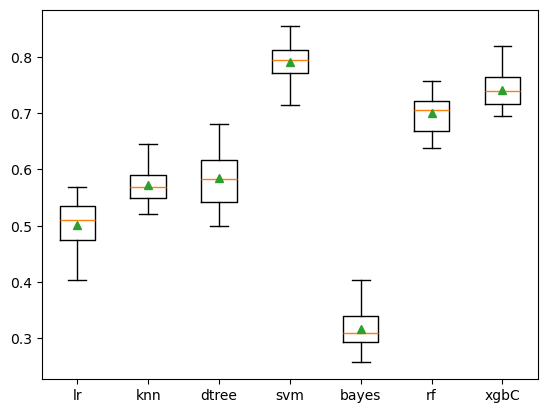

In [42]:
# Get the models to evaluate
models = get_models()
# Evaluate the models, store results, visualize results
# Here we are using only trainset
results, names = list(),list()
for name, model in models.items():
    scores = evaluate_model(model,X_train,y_train)
    results.append(scores)
    names.append(name)
    print(f"Model name {name}, mean of cv score: {np.mean(scores):.4f}, std of cv score: {np.std(scores):.4f}")
plt.boxplot(results,labels=names,showmeans=True)
plt.show()

## 3. Task 3: Hyperparameter Turning
-   Explore Numboer of Boosting rounds
-   Explore Tree Depth
-   Explore Learning Rate
-   Explore Number of Samples
-   Explore Number of Features

### 3.1 Explore Numboer of Boosting rounds
Define a function get list of models with different number of boosting rounds.

In [43]:
def get_models_estimator():
    models = dict()
    trees = [10,50,100,1000,5000]
    for n in trees:
        models[str(n)] = XGBClassifier(n_estimators = n)
    return models

In [ ]:
# Get the models to evaluate
models = get_models_estimator()
# Evaluate the models, store results, visualize results
# Here we are using only trainset
results, names = list(),list()
for name, model in models.items():
    scores = evaluate_model(model,X_train,y_train)
    results.append(scores)
    names.append(name)
    print(f"Model name {name}, mean of cv score: {np.mean(scores):.4f}, std of cv score: {np.std(scores):.4f}")
plt.boxplot(results,labels=names,showmeans=True)
plt.show()